In [24]:
# Imports & Load Dataset
import pandas as pd
import numpy as np
import re
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

# Load your dataset
csv_path = "final_file.csv"  # adjust if path differs
df = pd.read_csv(csv_path)
df.head()


,clause_text,clause_type
0,Absence of Certain Changes or Events. Except a...,absence-of-certain-changes-or-events
1,Absence of Certain Changes or Events. Since Ma...,absence-of-certain-changes-or-events
2,Absence of Certain Changes or Events. (a) Sinc...,absence-of-certain-changes-or-events
3,Absence of Certain Changes or Events. Since th...,absence-of-certain-changes-or-events
4,Absence of Certain Changes or Events. Except a...,absence-of-certain-changes-or-events


In [25]:
# Clean text
def clean_text(text):
    text = str(text).lower().strip()
    text = re.sub(r'[^a-z0-9\s\.\,\;\:\-\(\)]', '', text)
    return re.sub(r'\s+', ' ', text)

df['clean_text'] = df['clause_text'].apply(clean_text)

# Group by clause type
by_type = defaultdict(list)
for _, r in df.iterrows():
    by_type[r['clause_type']].append(r['clean_text'])

# Generate pairs
max_pos = 150
positive_pairs = []
negative_pairs = []
random.seed(42)
all_types = list(by_type.keys())

for t, texts in by_type.items():
    if len(texts) < 2: continue
    for _ in range(min(max_pos, len(texts)//2)):
        a, b = random.sample(texts, 2)
        positive_pairs.append((a, b, 1))

while len(negative_pairs) < len(positive_pairs):
    t1, t2 = random.sample(all_types, 2)
    a = random.choice(by_type[t1])
    b = random.choice(by_type[t2])
    negative_pairs.append((a, b, 0))

pairs = positive_pairs + negative_pairs
random.shuffle(pairs)

train_pairs, test_pairs = train_test_split(pairs, test_size=0.2, random_state=42, stratify=[p[2] for p in pairs])
print(f"Train: {len(train_pairs)}, Test: {len(test_pairs)}")


Train: 92700, Test: 23176


In [26]:
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data):
    for a, b, _ in data:
        yield tokenizer(a)
        yield tokenizer(b)

vocab = build_vocab_from_iterator(yield_tokens(train_pairs), specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab["<unk>"])

pad_idx = vocab["<pad>"]
print(f"Vocab size: {len(vocab)}")


Vocab size: 45475


In [27]:
class ClauseDataset(Dataset):
    def __init__(self, pairs, vocab, tokenizer, maxlen=100):
        self.pairs = pairs
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.maxlen = maxlen

    def encode(self, text):
        tokens = self.vocab(self.tokenizer(text))
        return torch.tensor(tokens[:self.maxlen], dtype=torch.long)

    def __getitem__(self, idx):
        a, b, label = self.pairs[idx]
        return self.encode(a), self.encode(b), torch.tensor(label, dtype=torch.float32)

    def __len__(self):
        return len(self.pairs)

def collate_fn(batch):
    a_seqs, b_seqs, labels = zip(*batch)
    a_padded = pad_sequence(a_seqs, batch_first=True, padding_value=pad_idx)
    b_padded = pad_sequence(b_seqs, batch_first=True, padding_value=pad_idx)
    return a_padded, b_padded, torch.stack(labels)

train_dataset = ClauseDataset(train_pairs, vocab, tokenizer)
test_dataset = ClauseDataset(test_pairs, vocab, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)


In [28]:
class SiameseBiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim*4, 64)
        self.fc2 = nn.Linear(64, 1)

    def encode(self, x):
        emb = self.embedding(x)
        _, (h, _) = self.lstm(emb)
        return torch.cat((h[-2], h[-1]), dim=1)

    def forward(self, a, b):
        a_enc = self.encode(a)
        b_enc = self.encode(b)
        diff = torch.abs(a_enc - b_enc)
        mult = a_enc * b_enc
        combined = torch.cat([diff, mult], dim=1)
        x = torch.relu(self.fc1(combined))
        return torch.sigmoid(self.fc2(x)).squeeze()


In [29]:
class AttentionEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.attention = nn.Linear(hidden_dim*2, 1)
        self.fc1 = nn.Linear(hidden_dim*4, 64)
        self.fc2 = nn.Linear(64, 1)

    def encode(self, x):
        emb = self.embedding(x)
        out, _ = self.lstm(emb)
        attn_weights = torch.softmax(self.attention(out), dim=1)
        context = (out * attn_weights).sum(dim=1)
        return context

    def forward(self, a, b):
        a_enc = self.encode(a)
        b_enc = self.encode(b)
        diff = torch.abs(a_enc - b_enc)
        mult = a_enc * b_enc
        combined = torch.cat([diff, mult], dim=1)
        x = torch.relu(self.fc1(combined))
        return torch.sigmoid(self.fc2(x)).squeeze()


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def train_model(model, train_loader, test_loader, epochs=3, lr=1e-3):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss()

    train_losses = []
    train_accuracies = [] # List to store training accuracies

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0
        for a, b, y in train_loader:
            a, b, y = a.to(device), b.to(device), y.to(device)
            opt.zero_grad()
            preds = model(a, b)
            loss = loss_fn(preds, y)
            loss.backward()
            opt.step()
            total_loss += loss.item()

            predicted_labels = (preds > 0.5).int()
            correct_predictions += (predicted_labels == y.int()).sum().item()
            total_samples += y.size(0)

        avg_loss = total_loss/len(train_loader)
        train_losses.append(avg_loss)
        epoch_accuracy = correct_predictions / total_samples
        train_accuracies.append(epoch_accuracy) # Store accuracy for the epoch

        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Accuracy: {epoch_accuracy:.4f}")

    # Evaluation
    model.eval()
    preds_list, labels_list = [], []
    with torch.no_grad():
        for a, b, y in test_loader:
            a, b = a.to(device), b.to(device)
            preds = model(a, b)
            preds_list.extend(preds.cpu().numpy())
            labels_list.extend(y.numpy())

    y_true = np.array(labels_list)
    y_pred = (np.array(preds_list) > 0.5).astype(int)
    print(classification_report(y_true, y_pred, digits=4))
    print("ROC-AUC:", roc_auc_score(y_true, preds_list))

    return train_losses, train_accuracies # Return both lists

Using device: cuda


In [31]:
bilstm_model = SiameseBiLSTM(len(vocab))
att_model = AttentionEncoder(len(vocab))

print("Training Siamese BiLSTM...")
bilstm_losses, bilstm_accuracies = train_model(bilstm_model, train_loader, test_loader, epochs=3)

print("\nTraining Attention Model...")
att_losses, att_accuracies = train_model(att_model, train_loader, test_loader, epochs=3)

Training Siamese BiLSTM...
Epoch 1/3 | Loss: 0.0107 | Accuracy: 0.9988
Epoch 2/3 | Loss: 0.0008 | Accuracy: 0.9997
Epoch 3/3 | Loss: 0.0006 | Accuracy: 0.9999
              precision    recall  f1-score   support

         0.0     0.9997    0.9997    0.9997     11588
         1.0     0.9997    0.9997    0.9997     11588

    accuracy                         0.9997     23176
   macro avg     0.9997    0.9997    0.9997     23176
weighted avg     0.9997    0.9997    0.9997     23176

ROC-AUC: 0.9999942695114237

Training Attention Model...
Epoch 1/3 | Loss: 0.0569 | Accuracy: 0.9670
Epoch 2/3 | Loss: 0.0006 | Accuracy: 0.9999
Epoch 3/3 | Loss: 0.0003 | Accuracy: 0.9999
              precision    recall  f1-score   support

         0.0     0.9997    0.9999    0.9998     11588
         1.0     0.9999    0.9997    0.9998     11588

    accuracy                         0.9998     23176
   macro avg     0.9998    0.9998    0.9998     23176
weighted avg     0.9998    0.9998    0.9998     23176

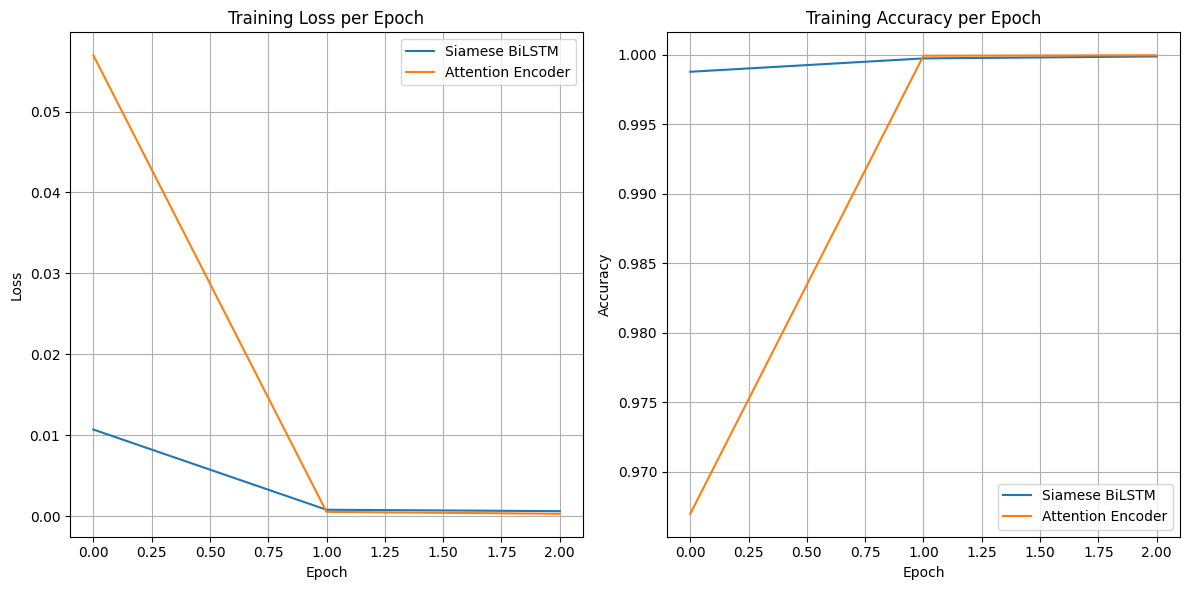

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(bilstm_losses, label='Siamese BiLSTM')
plt.plot(att_losses, label='Attention Encoder')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(bilstm_accuracies, label='Siamese BiLSTM')
plt.plot(att_accuracies, label='Attention Encoder')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()